In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class MovieRecommender(object):
    def __init__(self, ratings, movie_names, sigma, rank, lmbda):
        
        self.sigma  = sigma
        self.d      = np.identity(rank)
        self.lmbda = lmbda
        
        self.ratings      = ratings
        self.movie_names  = movie_names
        self.users        = ratings.groupby(0)
        self.movies       = ratings.groupby(1)
        self.movie_groups = ratings.groupby(1).groups.keys()
        
        mean = np.zeros(rank)
        cov  = lmbda * self.d
        self.movie_location_matrix = np.random.multivariate_normal(mean, cov, len(self.movie_groups))
        
        self.movie_locations = None
        self.user_locations  = None
    
    def movie_outer_prod(self, movie_id):
        movie_location = self.movie_locations[movie_id]
        return np.outer(movie_location, movie_location.T)
    
    def update_user(self, user_loc):
        x = np.linalg.inv((self.lmbda*self.sigma*self.d) + np.sum(user_loc[1].apply(self.movie_outer_prod)))
        y = np.dot(self.movie_locations[user_loc[1]], user_loc[2])
        return np.dot(x,y)
    
    def user_outer_prod(self, object_id):
        user_location = self.user_locations[object_id]
        return np.outer(user_location, user_location.T)
    
    def update_movie(self, movie_loc):
        x = np.linalg.inv((self.lmbda*self.sigma*self.d) + np.sum(movie_loc[0].apply(self.user_outer_prod)))
        y = np.dot(self.user_locations[movie_loc[0]], movie_loc[2])
        return np.dot(x,y)
    
    def objective_helper(self, loc):
        u = self.user_locations[loc[0]]
        v = self.movie_locations[loc[1]]
        rating = loc[2]
        prediction = np.dot(u, v)
        return rating - prediction
    
    def calculate_objective(self):
        user_norm  = (self.lmbda/2) * (self.user_locations.apply(np.linalg.norm).apply(np.square).sum())
        movie_norm = (self.lmbda/2) * (self.movie_locations.apply(np.linalg.norm).apply(np.square).sum())
        difference = (1/(2*self.sigma))*(self.ratings.apply(self.objective_helper, axis = 1).apply(np.square).sum())
        return (-difference - user_norm - movie_norm)
    
    def fill_ratings(self, iterations):
        self.objective_values = []
        
        ratings_grouped = pd.Series(pd.DataFrame(self.movie_location_matrix).values.tolist())
        ratings_grouped.index = self.movie_groups
        
        self.movie_locations = ratings_grouped.apply(np.asarray)
        
        for i in range(iterations):
            self.user_locations = self.users.apply(self.update_user)
            self.movie_locations = self.movies.apply(self.update_movie)
            self.objective_values.append(self.calculate_objective())
    
    def predict_single(self, test_point):
        try:
            u = self.user_locations[test_point[0]]
            v = self.movie_locations[test_point[1]]
            rating = np.dot(self.user_locations[test_point[0]], self.movie_locations[test_point[1]])
            return rating
        except Exception:
            pass
    
    def predict(self, test_set):
        predictions = test_set.apply(self.predict_single, axis = 1)
        return predictions
    
    def get_movie_loc(self, movie_name):
        movie_loc = self.movie_locations[self.movie_names[self.movie_names[0] == movie_name].index[0]]
        return movie_loc
    
    def get_closest(self, movie_loc, top, distance_func):
        closest = self.movie_locations.apply(distance_func, args = [movie_loc]).sort_values()[1:top+1]
        closest_info = movie_names.loc[pd.Series(closest.index)]
        closest_info.rename(index=int, columns={0: 'Movie'}, inplace = True)
        closest_info['Distance'] = closest.values

        return closest_info
        

In [3]:
def RMSE(y_test, predictions):
    rmse = (np.sqrt(((y_test - predictions)**2).mean()))
    return rmse

In [4]:
def distance(a, b):
    return np.linalg.norm(a-b)

In [5]:
sigma = 0.25
rank = 10
lmbda = 1

In [6]:
ratings = pd.read_csv('data/ratings.csv', header = None)
ratings_test = pd.read_csv('data/ratings_test.csv', header = None)
movie_names = pd.read_csv('data/movies.txt', sep = "\n", header = None)
movie_names.index += 1

In [7]:
recommenders = []
rmse = []
for i in range(10):
    movie_recommender = MovieRecommender(ratings, movie_names, sigma, rank, lmbda)
    movie_recommender.fill_ratings(100)
    recommenders.append(movie_recommender)
    predictions = movie_recommender.predict(ratings_test)
    rmse.append(RMSE(ratings_test[2], predictions))

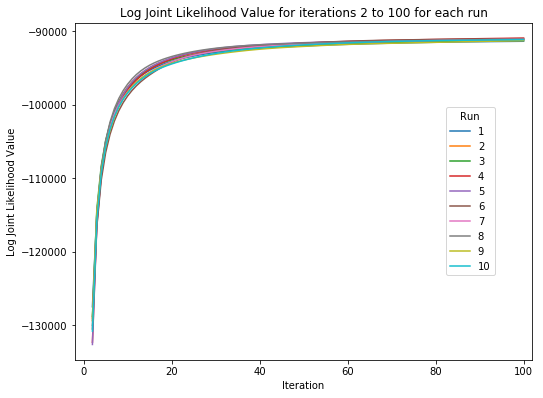

In [17]:
plt.figure(figsize=(8.2,6.2))
for i in range(10):
    plt.plot(list(range(2, 101)), recommenders[i].objective_values[1:], label = str(i+1))
plt.xlim([-2,102])
plt.title('Log Joint Likelihood Value for iterations 2 to 100 for each run')
plt.xlabel('Iteration')
plt.ylabel('Log Joint Likelihood Value')
plt.legend(title = 'Run', loc='center left', bbox_to_anchor=(.80, 0.5))     

In [30]:
final_objective_values = [recommender.objective_values[-1] for recommender in recommenders]
objective_rmse = list(zip(final_objective_values, rmse))
final_values_df = pd.DataFrame.from_records(objective_rmse, columns = ['Final Training Objective Value', 'RMSE on Test Set'])
final_values_df.sort_values('Final Training Objective Value', ascending = False, inplace = True)
final_values_df

,Final Training Objective Value,RMSE on Test Set
3,-90904.292168,1.119437
5,-90973.671041,1.100477
6,-91064.145414,1.112271
7,-91066.573909,1.120282
1,-91084.421710,1.147746
9,-91113.897711,1.121705
4,-91121.173403,1.110255
2,-91179.067136,1.137499
8,-91262.286663,1.118643
0,-91336.243192,1.116690


In [34]:
best_recommender = recommenders[final_values_df.index[0]]

In [35]:
star_wars = best_recommender.get_movie_loc('Star Wars (1977)')
best_recommender.get_closest(star_wars, 10, distance)

,Movie,distance
172,"Empire Strikes Back, The (1980)",0.348663
181,My name is Nitesh Surtani. I am currently taki...,0.599993
174,Raiders of the Lost Ark (1981),0.629504
173,"Princess Bride, The (1987)",0.795092
613,Lost Horizon (1937),0.851599
186,Psycho (1960),0.862825
612,Laura (1944),0.901344
210,This Is Spinal Tap (1984),0.905854
837,Ninotchka (1939),0.910792
12,"Usual Suspects, The (1995)",0.946868


In [36]:
fair_lady = best_recommender.get_movie_loc('My Fair Lady (1964)')
best_recommender.get_closest(fair_lady, 10, distance)

,Movie,distance
485,"Maltese Falcon, The (1941)",0.508757
275,Sabrina (1995),0.564114
633,Sophie's Choice (1982),0.572834
283,"Time to Kill, A (1996)",0.630787
143,"Sound of Music, The (1965)",0.632623
1147,Calendar Girl (1993),0.635893
419,Cinderella (1950),0.660752
1050,House Arrest (1996),0.686867
418,"Parent Trap, The (1961)",0.739174
507,Rebel Without a Cause (1955),0.753024


In [37]:
good_fellas = best_recommender.get_movie_loc('GoodFellas (1990)')
best_recommender.get_closest(good_fellas, 10, distance)

,Movie,distance
530,My Life as a Dog (Mitt liv som hund) (1985),0.465821
523,Down by Law (1986),0.557956
177,"Good, The Bad and The Ugly, The (1966)",0.591011
176,Aliens (1986),0.606376
195,"Sting, The (1973)",0.663482
188,"Godfather: Part II, The (1974)",0.674481
144,Die Hard (1988),0.676939
302,In & Out (1997),0.695817
211,Indiana Jones and the Last Crusade (1989),0.699525
199,Nikita (La Femme Nikita) (1990),0.702665
